## Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss

import helper 
from models_stationary import *


current_path = os.getcwd()

random_state = helper.RANDOM_STATE

# Define a context manager to temporarily suppress FutureWarnings
class SuppressFutureWarnings:
    def __enter__(self):
        warnings.filterwarnings('ignore', category=FutureWarning)
    
    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('default')

In [3]:
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^IRX"]
START_DATE = helper.START_DATE
END_DATE = helper.END_DATE
stock_data = {}
MAs = [5, 10, 20, 50, 100, 200]
for stock in STOCKS: 
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    data['Date'] = pd.to_datetime(data['Date'])
    if stock != "^IRX":
        data['RSI'] = helper.compute_rsi(data['Close'])
        data['rsi_class'] = helper.compute_rsi_class(data)  # Assuming you have this function in helper
        #data['volume_class'] = helper.compute_volume_class(data)  # Add volume analysis
        data = helper.calculate_mas(data, MAs, column_name="Close")
        data['WVAD'] = helper.calculate_wvad(data, period=14)
        data['ROC'] = helper.calculate_roc(data, period=14)
        data['MACD'], data['macd_line'], data['signal_line'] = helper.calculate_macd(data, short_window=12, long_window=26, signal_window=9)
        data['CCI'] =  helper.calculate_cci(data, period=20)
        data['Upper Band'], data['Lower Band'], data['SMA'] = helper.calculate_bollinger_bands(data, window=20, num_std_dev=2)
        data['SMI'] = helper.calculate_smi(data, period=14, signal_period=3)
        data['ATR'] = helper.calculate_atr(data, period=14)
        data[['WVF', 'upperBand', 'rangeHigh', 'WVF_color']] = helper.cm_williams_vix_fix(data['Close'], data['Low'])
        data[['Buy_Signal', 'Sell_Signal', 'BB_Upper', 'BB_Lower']] = helper.bollinger_rsi_strategy(data['Close'])
        data = helper.on_balance_volume(data)
        data = helper.volume_price_trend(data)
        data = helper.money_flow_index(data)
        data = helper.accumulation_distribution(data)
        data = data.dropna()
    stock_data[stock] = data
    print(f"Data fetched for {stock}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


## Stationarity Check

In [4]:
significance_level = 0.05  
data = stock_data['AAPL']
results = []

for feature in data.columns:
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
print(nonstationary_features_list)
feature_stationarity.sort_values('p-value', ascending=False)


['Open', 'VPT', 'BB_Lower', 'BB_Upper', 'ATR', 'SMA', 'Lower Band', 'Upper Band', 'MA200', 'MA100', 'AD', 'MA20', 'High', 'Low', 'Close', 'MA50', 'Volume', 'MA5', 'Adj Close', 'MA10']


,Feature,Stationarity,p-value
10,MA50,nonstationary,9.859434e-01
30,BB_Upper,nonstationary,9.852933e-01
19,Upper Band,nonstationary,9.696534e-01
8,MA10,nonstationary,9.598414e-01
7,MA5,nonstationary,9.581930e-01
9,MA20,nonstationary,9.568627e-01
21,SMA,nonstationary,9.568627e-01
20,Lower Band,nonstationary,9.550818e-01
1,High,nonstationary,9.442359e-01
2,Low,nonstationary,9.424528e-01


In [5]:
for stock in stock_data: 
    data = stock_data[stock]
    if stock != "^IRX":
        # convert price related features into something stationary
        for feature in helper.PRICE_FEATURES_TO_CONVERT:
            data[feature] = (data[feature] - data['Close']) / data['Close']
        for feature in helper.ORIGINAL_PRICE_FEATURES:
            data[f'{feature}_diff'] = data[feature].pct_change() * 100

        # convert volume related features into something stationary
        data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
        data['Volume_MA_diff'] = (data['Volume'] - data['Volume_MA5'])/(data['Volume_MA5'])
            
        data = data.dropna()
    stock_data[stock] = data
    print(f"Data fetched for {stock}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


In [6]:
data = stock_data['AAPL']
results = []

for feature in data.columns.drop(helper.ORIGINAL_PRICE_FEATURES + helper.VOLUME_FEATURES_TO_CONVERT):
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
feature_stationarity.sort_values('p-value', ascending=False)


,Feature,Stationarity,p-value
17,ATR,nonstationary,4.661265e-01
27,VPT,nonstationary,2.468781e-01
35,Volume_MA5,nonstationary,1.142711e-01
29,AD,stationary,3.059457e-02
25,BB_Lower,stationary,4.563890e-03
6,MA200,stationary,3.752741e-03
24,BB_Upper,stationary,1.645676e-03
26,OBV,stationary,1.102144e-03
5,MA100,stationary,1.086421e-06
20,rangeHigh,stationary,3.646160e-07


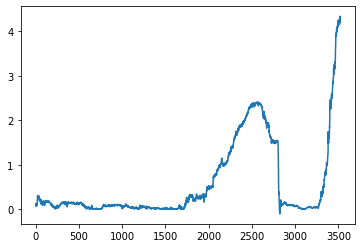

In [7]:
plt.plot(stock_data['^IRX']['Close'])

## Model

### XGBoost

#### APPLE

In [42]:
fromDate = "2015-01-01"
toDate = '2020-01-01'
stock = 'AAPL'
window_size = 200
lag = 5
starting_funds = 50000
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, lag=lag)
    xgboost_stock_predictor.fit_predict()
    xgboost_stock_predictor.print_metrics()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing: 100%|██████████| 1041/1041 [01:04<00:00, 16.19it/s]

Mean Squared Error (MSE): 3.0803
Root Mean Squared Error (RMSE): 1.7551
Mean Absolute Error (MAE): 1.2710


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


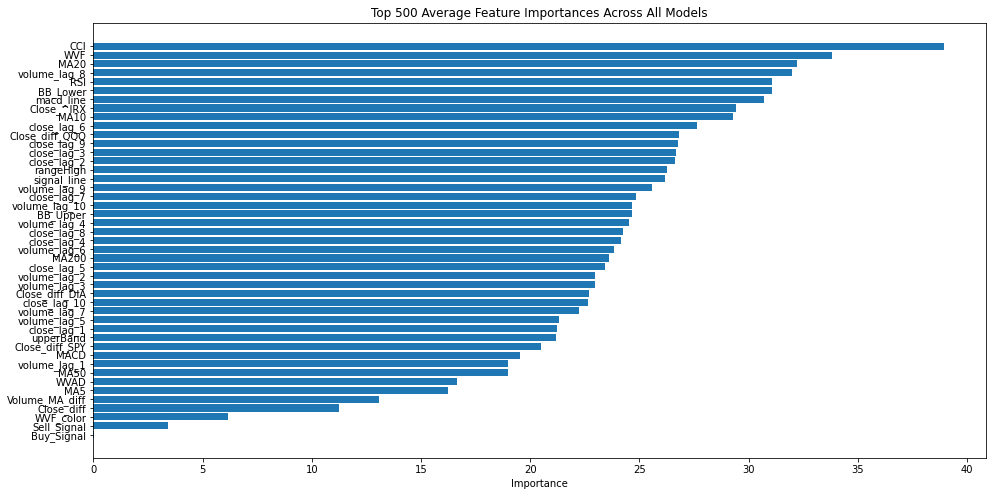

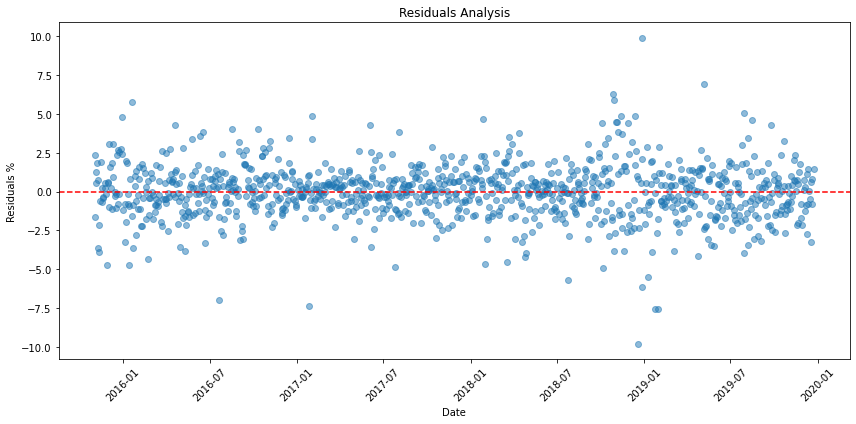

In [43]:
xgboost_stock_predictor.show_feature_importance(500)
xgboost_stock_predictor.plot_residuals()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


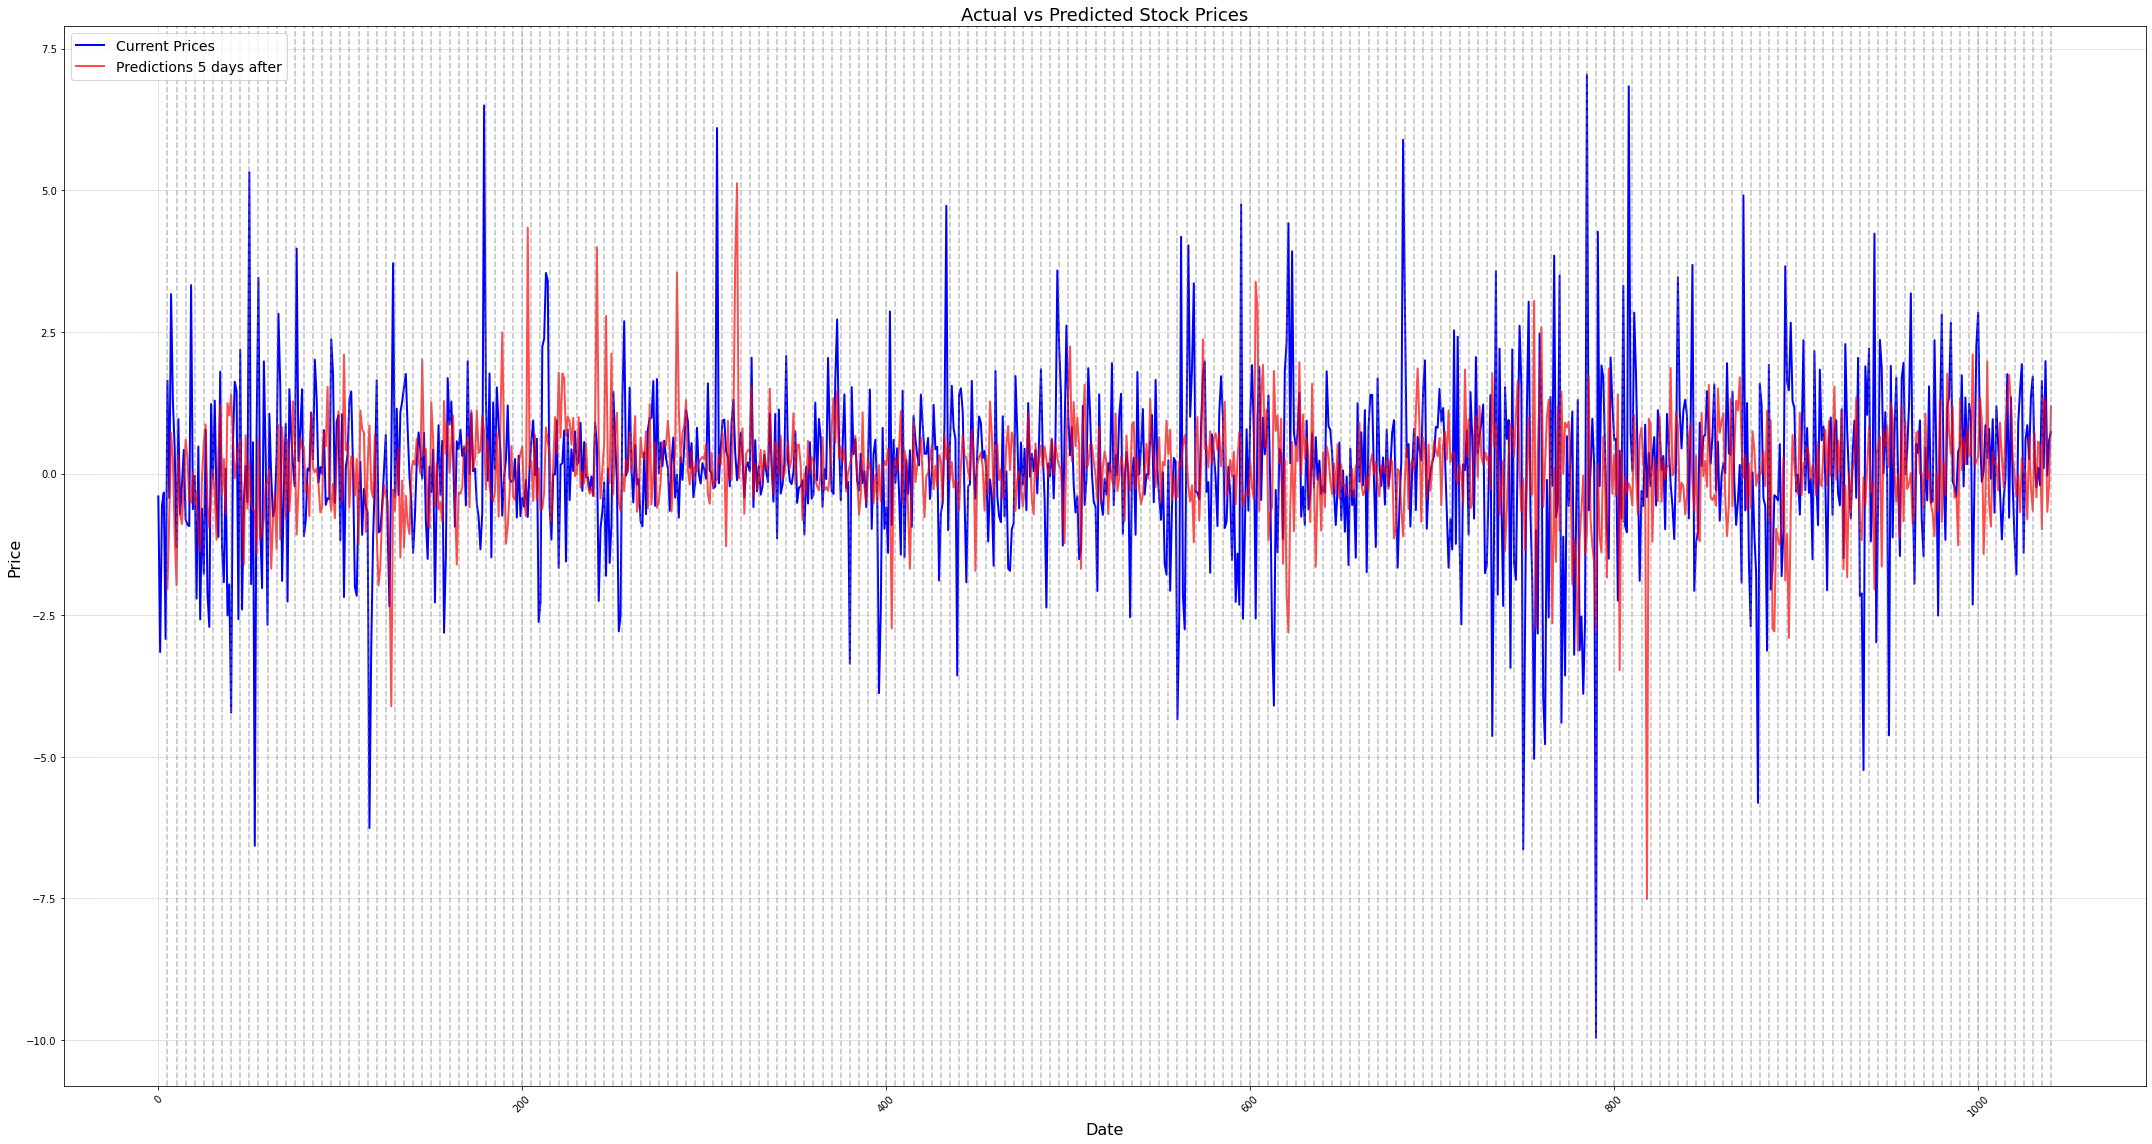

In [64]:
xgboost_stock_predictor.plot_actual_vs_predicted()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


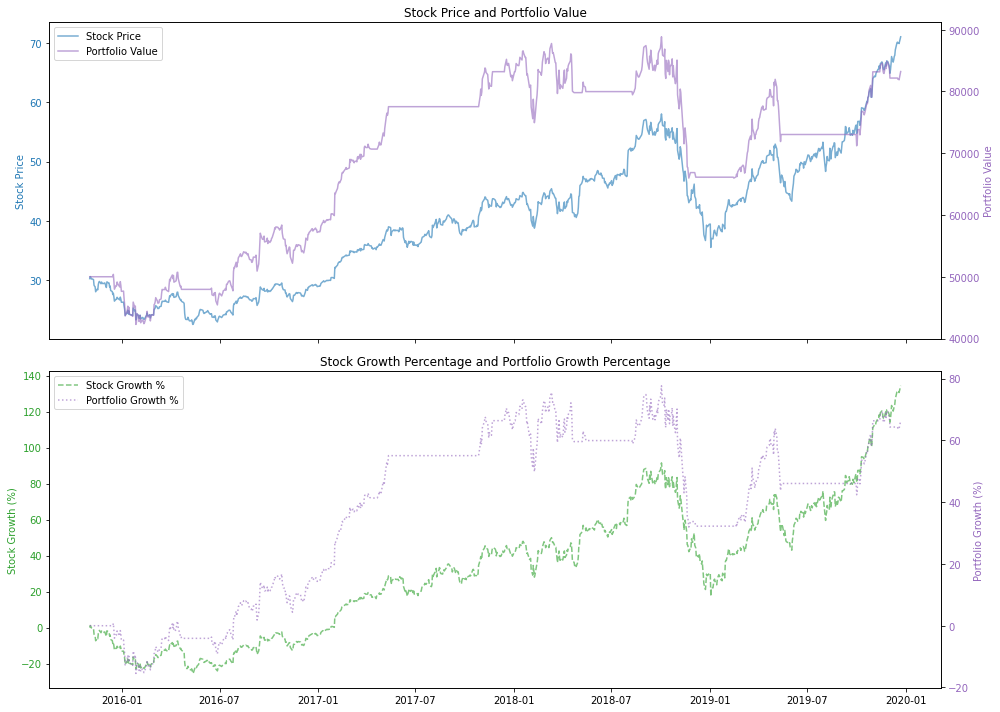

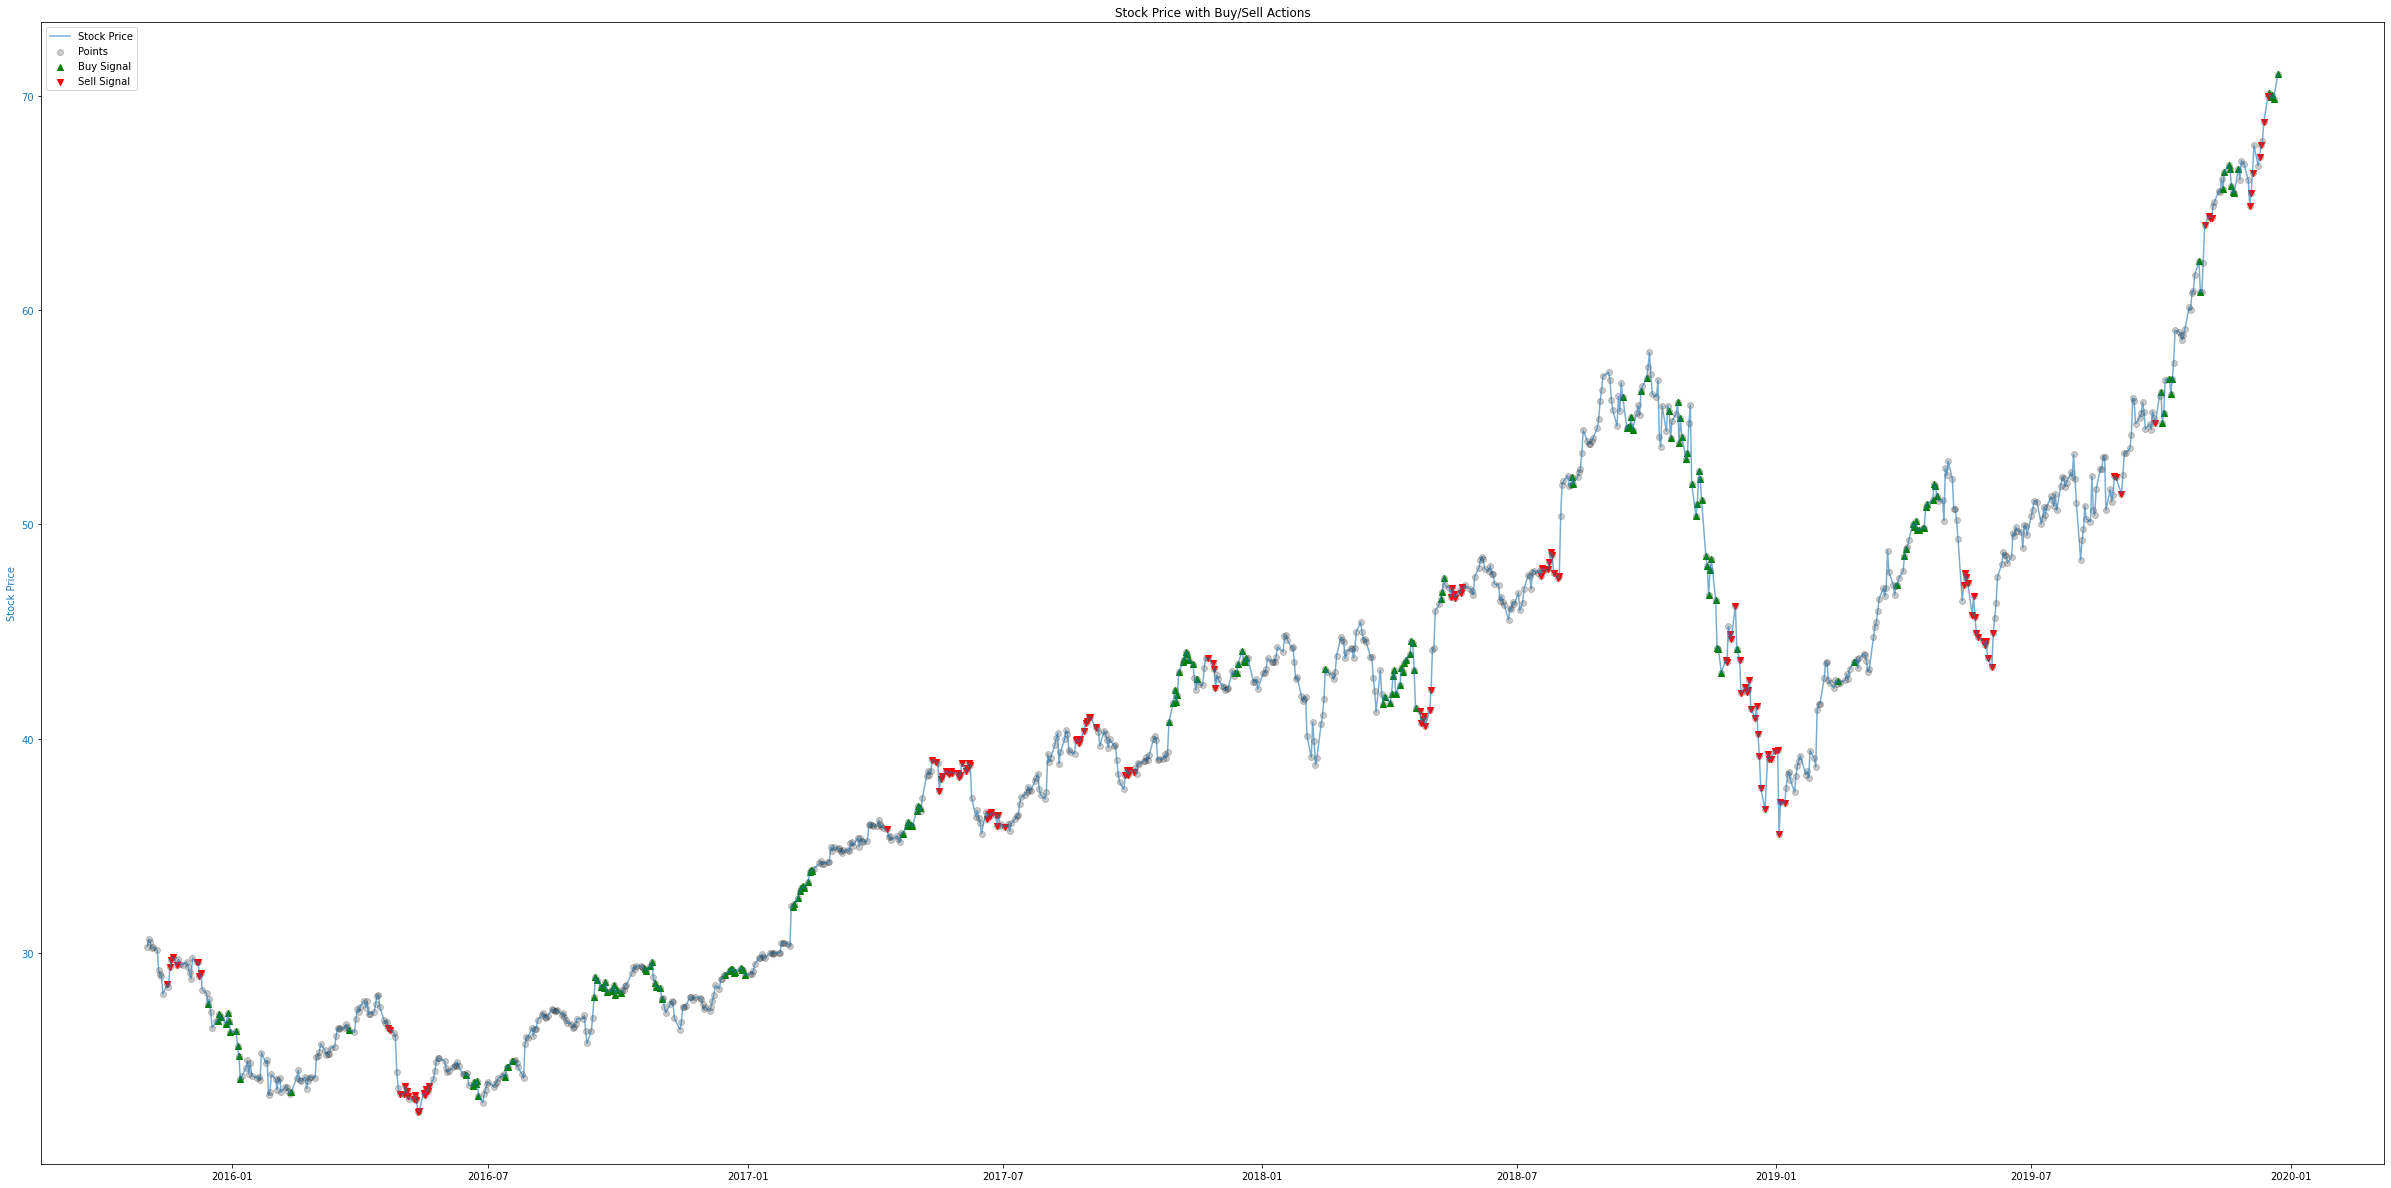

In [68]:
xgboost_stock_predictor.trading_strategy(window_size=window_size, starting_funds=starting_funds)

#### window size analysis 

In [8]:
fromDate = "2021-01-01"
toDate = '2023-01-01'
stock = 'AAPL'
window_sizes = [5, 20, 80, 160, 320, 640, 1280, 2560]
late = 5
starting_funds = 50000
loss_fn = 'reg:squarederror'  # 'reg:pseudohubererror'

mape_values = []

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    for window in window_sizes:
        xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window, lag=late)
        xgboost_stock_predictor.fit_predict()
        xgboost_stock_predictor.print_metrics()
        mape_values.append(xgboost_stock_predictor.MSE)

Processing: 100%|██████████| 483/483 [00:13<00:00, 34.96it/s]


Mean Squared Error (MSE): 7.3095
Root Mean Squared Error (RMSE): 2.7036
Mean Absolute Error (MAE): 2.0298


Processing: 100%|██████████| 468/468 [00:15<00:00, 30.69it/s]


Mean Squared Error (MSE): 6.8238
Root Mean Squared Error (RMSE): 2.6122
Mean Absolute Error (MAE): 1.9663


Processing: 100%|██████████| 408/408 [00:16<00:00, 24.73it/s]


Mean Squared Error (MSE): 5.9533
Root Mean Squared Error (RMSE): 2.4399
Mean Absolute Error (MAE): 1.8593


Processing: 100%|██████████| 328/328 [00:17<00:00, 18.82it/s]


Mean Squared Error (MSE): 6.4626
Root Mean Squared Error (RMSE): 2.5422
Mean Absolute Error (MAE): 1.9589


Processing: 100%|██████████| 168/168 [00:12<00:00, 12.97it/s]


Mean Squared Error (MSE): 8.2031
Root Mean Squared Error (RMSE): 2.8641
Mean Absolute Error (MAE): 2.2073


Processing: 0it [00:00, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


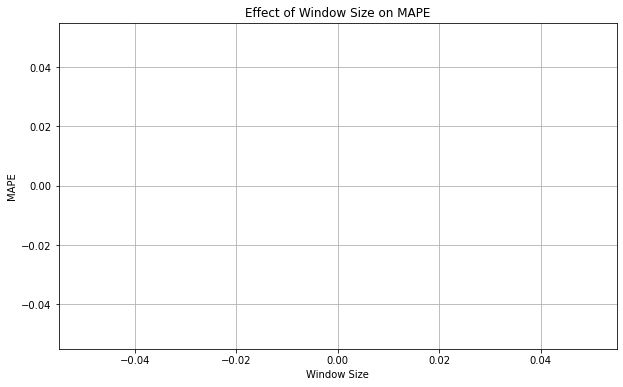

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(window_sizes[:len(mape_values)], mape_values, marker='o', linestyle='-')
plt.xlabel('Window Size')
plt.ylabel('MAPE')
plt.title('Effect of Window Size on MAPE')
plt.grid(True)
plt.show()

#### performance in various stocks

In [ ]:
min_mape_value = min(mape_values)
optimal_window_size = window_sizes[mape_values.index(min_mape_value)]
for stock in ["TSLA", "AAPL", "MSFT", "AMZN", "GOOG"]:
    # fromDate = "2015-01-01"
    # toDate = '2017-01-01'
    fromDate = "2010-01-01"
    toDate = '2023-01-01'
    window_size = optimal_window_size
    late = 5
    starting_funds = 50000
    loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

    with SuppressFutureWarnings():
        print(stock)
        xgboost_model = XGBoostModel(loss_fn)
        xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, late=late)
        xgboost_stock_predictor.fit_predict()
        xgboost_stock_predictor.print_metrics()
        print("==="*9)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TSLA


Processing: 100%|██████████| 2939/2939 [01:27<00:00, 33.45it/s]


Mean Squared Error (MSE): 32.22608128946541
Mean Absolute Percentage Error (MAPE): 3.16%
Root Mean Squared Error (RMSE): 5.676802030145618
AAPL


Processing: 100%|██████████| 3061/3061 [01:31<00:00, 33.35it/s]


Mean Squared Error (MSE): 3.458906869890099
Mean Absolute Percentage Error (MAPE): 1.64%
Root Mean Squared Error (RMSE): 1.8598136653681463
MSFT


Processing: 100%|██████████| 3061/3061 [01:32<00:00, 33.26it/s]


Mean Squared Error (MSE): 11.11895563102922
Mean Absolute Percentage Error (MAPE): 1.46%
Root Mean Squared Error (RMSE): 3.3345098037086682
AMZN


Processing: 100%|██████████| 3061/3061 [01:31<00:00, 33.41it/s]


Mean Squared Error (MSE): 5.597891600063091
Mean Absolute Percentage Error (MAPE): 1.87%
Root Mean Squared Error (RMSE): 2.3659863905067358
GOOG


Processing: 100%|██████████| 3061/3061 [01:31<00:00, 33.42it/s]

Mean Squared Error (MSE): 2.3202525681606776
Mean Absolute Percentage Error (MAPE): 1.51%
Root Mean Squared Error (RMSE): 1.5232375284769863


## Random Forest

### APPLE

In [27]:
fromDate = "2017-01-01"
toDate = '2023-01-01'
stock = 'AAPL'
window_size = 200
lag = 5
starting_funds = 50000
loss_fn = 'squared_error'

with SuppressFutureWarnings():  
    rf_model = RandomForest(loss_fn)
    rf_stock_predictor = StockPredictor(stock_data, rf_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, lag=lag)
    rf_stock_predictor.fit_predict()
    rf_stock_predictor.print_metrics()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing:  19%|█▉        | 249/1295 [01:13<05:10,  3.37it/s]


KeyboardInterrupt: 

### LSTM, inspired by A deep learning framework for financial time series using stacked autoencoders and longshort term memory

## other

In [ ]:
def determine_trend(df, short_window=50, long_window=200, threshold=0.01):
    """
    Determine the trend based on moving averages.
    
    Parameters:
    - df: DataFrame with the stock data
    - short_window: Window for the short-term SMA
    - long_window: Window for the long-term SMA
    - threshold: Percentage difference between SMAs to consider as 'No trend'
    
    Returns:
    - trend: List with 'Uptrend', 'Downtrend' or 'No trend' for each row in df
    """
    # Calculate short and long moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    # Calculate the trend
    conditions = [
        (df['Short_MA'] > df['Long_MA'] * (1 + threshold)), # Uptrend condition
        (df['Short_MA'] < df['Long_MA'] * (1 - threshold))  # Downtrend condition
    ]
    choices = ['Uptrend', 'Downtrend']
    
    df['Trend'] = np.select(conditions, choices, default='No trend')
    
    return df['Trend'].tolist()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
stock_apple = stock_data['AAPL'].copy()
stock_apple['Trend'] = determine_trend(stock_apple)


In [ ]:
def plot_stock_with_trend(df):
    apdict = [mpf.make_addplot(df['Short_MA'], color='blue', linestyle='--'),
              mpf.make_addplot(df['Long_MA'], color='red', linestyle='--')]
    
    mpf.plot(df, type='candle', style='yahoo', volume=True, title='Stock with Trend Indicator',
             ylabel='Price', figratio=(400, 120), mav=(100, 400), addplot=apdict, 
             hlines=dict(hlines=[df['Close'].mean()], colors=['blue'], linewidths=[2]))

plot_stock_with_trend(stock_apple)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Expect data.index as DatetimeIndex

In [ ]:
# Calculate the weekly return
stock_apple['Weekly_Return'] = stock_apple['Close'].resample('W').ffill().pct_change()


# Display statistics
stats = stock_apple['Weekly_Return'].describe()
stats